# Predictive Modeling
## 1. Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('../data/modified_data.csv', index_col=0)
# Shuffle rows
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data.head()

,Year,Player,Age,Tm,G,TS%,3PAr,FTr,TRB%,AST%,STL%,BLK%,TOV%,USG%,WS,WS/48,3P%,FT%,Pick,GS%,FGA/48,PF/48,MPG,Improvement,Frontcourt,Imprv_prev_year,Tm_WS,Tm_next,Change_team
0,2001.0,Lamar Odom,21,LAC,76.0,0.536,0.242,0.369,11.9,25.0,1.4,3.0,17.8,24.1,6.5,0.111,0.316,0.679,4.0,0.973684,17.703808,3.994358,37.315789,-5.80000,1,3.3,34.6,LAC,True
1,2016.0,D.J. Augustin,28,OKC,62.0,0.575,0.480,0.366,4.4,25.3,1.6,0.3,17.1,18.0,2.6,0.106,0.405,0.805,9.0,0.000000,14.261460,3.463497,19.000000,-1.40000,0,-0.8,61.9,ORL,False
2,2011.0,Gilbert Arenas,29,ORL,70.0,0.471,0.446,0.208,6.1,25.3,2.1,0.9,18.1,24.7,0.5,0.014,0.297,0.784,30.0,0.228571,19.616927,5.024499,25.657143,-0.00303,0,-1.3,54.4,MEM,False
3,2006.0,Matt Carroll,25,CHA,78.0,0.540,0.389,0.353,7.1,4.6,1.9,0.7,8.0,20.8,2.6,0.097,0.389,0.821,61.0,0.076923,17.920000,4.517647,16.346154,2.00000,0,1.9,32.5,CHA,True
4,2010.0,Caron Butler,29,WAS,74.0,0.507,0.138,0.300,9.5,9.2,2.2,0.7,11.9,22.1,3.5,0.061,0.290,0.838,10.0,1.000000,18.127201,3.328782,37.608108,-2.30000,0,-1.0,34.1,DAL,False


In [3]:
# Separate target data
target = data['Improvement']
data.drop('Improvement', axis=1, inplace=True)
# Drop columns that are not going to be used for modeling.
data.drop(['Year','Player','Tm','Tm_next','WS'], axis=1, inplace=True)
# Since a lot of the features are percentages, I think it makes the most sense to scale the data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [4]:
# Create training and testing sets
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(scaled_data, target.values, random_state=42)

## 2. Regression models
### 2.1 Establish benchmark
In EDA, I saw a clean negative relationship between player improvement and age. I will build a simple linear model using age and use that as the benchmark.

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# Find the column index of 'Age'
age_col = data.columns.tolist().index('Age')
# Run the simple linear regression model based on age
lm = LinearRegression()
lm.fit(Xtrain[:,age_col].reshape(-1,1), ytrain)
ypred = lm.predict(Xtest[:,age_col].reshape(-1,1))
print('RMSE of simple linear model is', np.sqrt(mean_squared_error(ytest, ypred)))

RMSE of simple linear model is 2.1564883117402265


### 2.2 Linear Models
#### 2.2.1 Linear Regression

In [6]:
lm = LinearRegression()
lm.fit(Xtrain, ytrain)
ypred = lm.predict(Xtest)
print('RMSE of linear regression model is', np.sqrt(mean_squared_error(ytest, ypred)))

RMSE of linear regression model is 1.9511560739912464


In [7]:
# Take a look at coefficients to see which features are most important
print(pd.Series(lm.coef_, index=data.columns))

Age               -3.204844
G                 -1.473186
TS%                0.603900
3PAr              -0.135424
FTr                0.962913
TRB%               1.682731
AST%               1.173016
STL%               0.574408
BLK%               1.052296
TOV%               0.226395
USG%              -1.482357
WS/48             -4.345864
3P%                0.176573
FT%                0.935251
Pick              -0.325538
GS%               -0.655238
FGA/48             1.373464
PF/48             -0.581360
MPG                0.344272
Frontcourt        -0.219830
Imprv_prev_year   -6.171432
Tm_WS             -0.082938
Change_team        0.398152
dtype: float64


The linear regression model reduced the RMSE by 10%. The most important features are age, WS/48(how good a player is), and improvement last year.<br>
Let's try linear models with regularization.
#### 2.2.2 Ridge Regression

In [8]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
# Grid search alpha and l1_ratio
lm = Ridge(random_state=42)
params = {
    'alpha':[0.01, 0.1, 1, 10]
}
# Write a function that runs GridSearchCv, and output results
def grid_search_cv(regressor, params, Xtrain, ytrain):
    model = GridSearchCV(regressor, params, scoring='neg_mean_squared_error')
    model.fit(Xtrain, ytrain)
    print('Best parameters were', model.best_params_)
    print('Best RMSE was', np.sqrt(-1*model.best_score_))
grid_search_cv(lm, params, Xtrain, ytrain)

Best parameters were {'alpha': 1}
Best RMSE was 1.9995255535212086


In [9]:
lm = Ridge(alpha=0.1, random_state=42)
lm.fit(Xtrain, ytrain)
ypred = lm.predict(Xtest)
print('RMSE of Ridge regression model is', np.sqrt(mean_squared_error(ytest, ypred)))

RMSE of Ridge regression model is 1.9511617026039976


In [10]:
print(pd.Series(lm.coef_, index=data.columns))

Age               -3.202538
G                 -1.473521
TS%                0.571994
3PAr              -0.136580
FTr                0.942096
TRB%               1.662857
AST%               1.152549
STL%               0.565592
BLK%               1.044821
TOV%               0.243955
USG%              -1.425294
WS/48             -4.291855
3P%                0.175364
FT%                0.928733
Pick              -0.325716
GS%               -0.654531
FGA/48             1.324346
PF/48             -0.579759
MPG                0.341579
Frontcourt        -0.219704
Imprv_prev_year   -6.159656
Tm_WS             -0.094518
Change_team        0.398209
dtype: float64


There was almost no difference between the linear regression model and the Ridge regression model.

#### 2.2.3 Lasso Regression

In [11]:
from sklearn.linear_model import Lasso
# Grid search alpha and l1_ratio
lm = Lasso(random_state=42)
params = {
    'alpha':[1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1]
}
grid_search_cv(lm, params, Xtrain, ytrain)

Best parameters were {'alpha': 1e-05}
Best RMSE was 1.999555157488054


In [12]:
lm = Lasso(alpha=1e-5, random_state=42)
lm.fit(Xtrain, ytrain)
ypred = lm.predict(Xtest)
print('RMSE of Lasso regression model is', np.sqrt(mean_squared_error(ytest, ypred)))

RMSE of Lasso regression model is 1.95114663149392


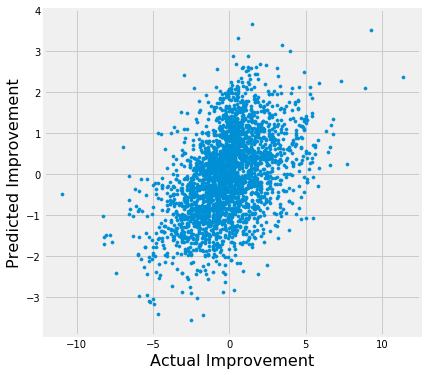

In [13]:
def plot_predict_true(ytest, ypred):
    plt.figure(figsize=(6,6))
    _ = plt.scatter(ytest, ypred, s=10)
    _ = plt.xlabel('Actual Improvement', fontsize=16)
    _ = plt.ylabel('Predicted Improvement', fontsize=16)
plot_predict_true(ytest, ypred)

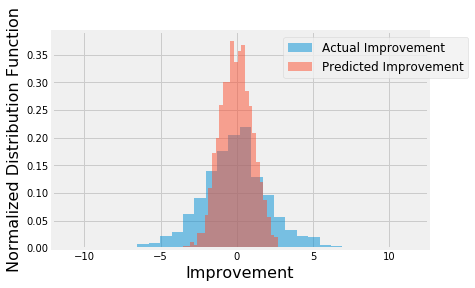

In [14]:
# The prediction space was tighter than the distribution of actual values.
_ = plt.hist(ytest, bins=30, alpha=0.5, normed=True, label='Actual Improvement')
_ = plt.hist(ypred, bins=30, alpha=0.5, normed=True, label='Predicted Improvement')
_ = plt.xlabel('Improvement', fontsize=16)
_ = plt.ylabel('Normalized Distribution Function', fontsize=16)
_ = plt.legend(fontsize=12, bbox_to_anchor=(0.6,1))

In [15]:
# Try to scale the predicted improvement up to match the range of actual improvements
# and evaluate the performances.
for i in np.linspace(1.5, 3, 16):
    ypred_copy = ypred * i
    print('Factor = {:.1f}, RMSE = {}'.format(i, np.sqrt(mean_squared_error(ytest, ypred_copy))))

Factor = 1.5, RMSE = 2.0320245647539137
Factor = 1.6, RMSE = 2.064101135527701
Factor = 1.7, RMSE = 2.1010052376516684
Factor = 1.8, RMSE = 2.142487424612413
Factor = 1.9, RMSE = 2.188287359017207
Factor = 2.0, RMSE = 2.2381399892938467
Factor = 2.1, RMSE = 2.2917808583605033
Factor = 2.2, RMSE = 2.3489504547453826
Factor = 2.3, RMSE = 2.4093976052073796
Factor = 2.4, RMSE = 2.472881971736452
Factor = 2.5, RMSE = 2.539175755501941
Factor = 2.6, RMSE = 2.608064729554873
Factor = 2.7, RMSE = 2.679348725865485
Factor = 2.8, RMSE = 2.752841695607549
Factor = 2.9, RMSE = 2.8283714487993774
Factor = 3.0, RMSE = 2.90577916379086


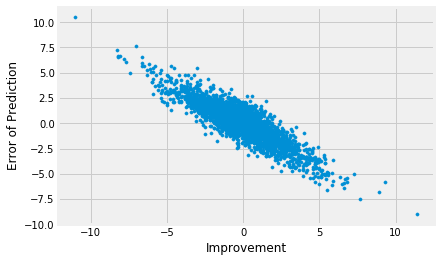

In [16]:
# No, it doesn't work. If I scale up the predictions, error only increase.
# Take a look at residual vs target value
_ = plt.scatter(ytest, ypred-ytest, s=10)
_ = plt.xlabel('Improvement')
_ = plt.ylabel('Error of Prediction')

The errors change with target values. This is not right. Linear regression models should have constant errors regardless of the predicted value. I think the reason we are seeing this is because there are more samples with smaller values(closer to 0) than those with larger values. So the weights of samples are unbalanced in determining the mean squared error. In other words, since there are more samples with smaller values, the models try to prioritize minimizing errors on those samples and tend to ignore samples with larger values.<br>
To remedy this, I can assign weights to samples, with weights being inverse proportional to the number of samples with similar target values.

In [17]:
from collections import Counter
def calc_weights(y):
    # Values outside 6 and -6 can be considered outliers and not give too much weight
    y_copy = y.copy()
    y_copy[y_copy>6] = 6
    y_copy[y_copy<-6] = -6
    # Count samples with different target values (using bins with width 1)
    n_samples = Counter(np.round(y_copy, 0))
    # Calculate weights = 1/n(samples with similar y)
    def transform_values(value):
        if value > 6:
            return 1/n_samples[6]
        elif value < -6:
            return 1/n_samples[-6]
        else:
            return 1/n_samples[np.round(value, 0)]
    return np.vectorize(transform_values)(y)
# Calculate weights for training set
ytrain_weights = calc_weights(ytrain)

In [18]:
# Run the linear regression with weights
lm = LinearRegression()
lm.fit(Xtrain, ytrain, sample_weight=ytrain_weights)
ypred = lm.predict(Xtest)

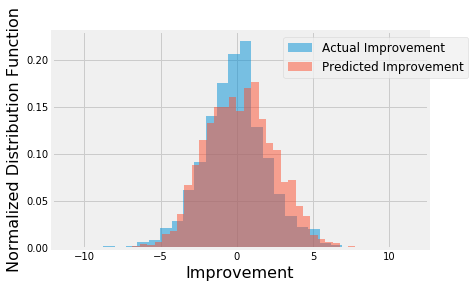

In [19]:
# Check distribution of prediction again
_ = plt.hist(ytest, bins=30, alpha=0.5, normed=True, label='Actual Improvement')
_ = plt.hist(ypred, bins=30, alpha=0.5, normed=True, label='Predicted Improvement')
_ = plt.xlabel('Improvement', fontsize=16)
_ = plt.ylabel('Normalized Distribution Function', fontsize=16)
_ = plt.legend(fontsize=12, bbox_to_anchor=(0.6,1))

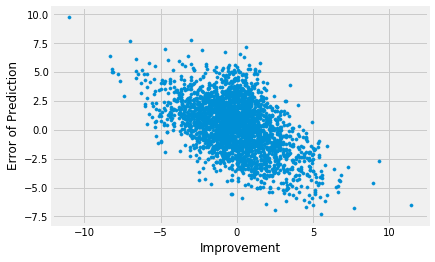

In [20]:
# Check residual and true value again
_ = plt.scatter(ytest, ypred-ytest, s=10)
_ = plt.xlabel('Improvement')
_ = plt.ylabel('Error of Prediction')

With the weighted method, the range of predicted values is more similar to the range of actual values. In terms of errors, it is still not constant across different target values. We can see the weighted model have higher errors for smaller values and lower errors for larger values compared to the unweighted model.<br>
Practically speaking, accuracy on larger values is more important than accuracy on smaller values, because players with large improvement/decline have more impact on the team as players whose performance did not change much. So it might be worthwhile to sacrifice some accuracy on the smaller values to achieve accuracy on larger values.

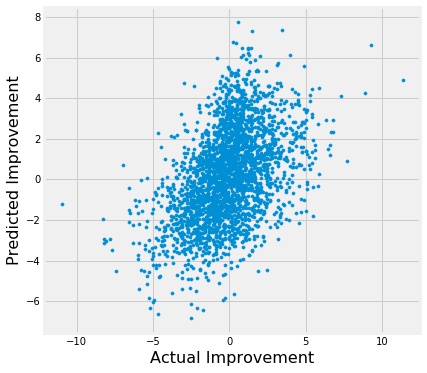

In [21]:
# Plot the prediction against true values again
plot_predict_true(ytest, ypred)

In [22]:
# Recalculate the mean squared error with sample weights
# Calculate sample weights for the test set.
ytest_weights = calc_weights(ytest)
print('The root of weighted squared error of this model is', 
      np.sqrt(mean_squared_error(ytest, ypred, sample_weight=ytest_weights)))

The root of weighted squared error of this model is 2.9879847926047267


In [23]:
# Re-evaluate the bench mark model using the same metric.
lm = LinearRegression()
lm.fit(Xtrain[:,age_col].reshape(-1,1), ytrain)
ypred = lm.predict(Xtest[:,age_col].reshape(-1,1))
print('The root of weighted squared error of this model is', 
      np.sqrt(mean_squared_error(ytest, ypred, sample_weight=ytest_weights)))

The root of weighted squared error of this model is 3.839567556276467


### 2.3. SVM

In [24]:
from sklearn.svm import SVR
svr = SVR()
params = {
    'C': [1, 10, 100, 1000]
}
grid_search_cv(svr, params, Xtrain, ytrain)

Best parameters were {'C': 100}
Best RMSE was 1.9865706111325192


In [25]:
svr = SVR(C=100)
svr.fit(Xtrain, ytrain)
ypred = svr.predict(Xtest)
print('RMSE of SVM model is', np.sqrt(mean_squared_error(ytest, ypred)))

RMSE of SVM model is 1.9305697136101487


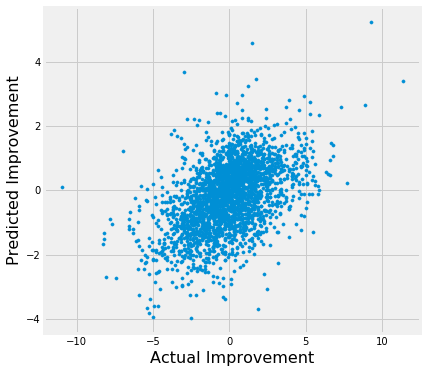

In [26]:
plot_predict_true(ytest, ypred)

RMSE is slightly better than linear models.
### 2.4. Random Forest

In [27]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
params = {
    'n_estimators': [101, 201, 401, 601, 801, 1001],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 10, 20, 50]
}
grid_search_cv(rf, params, Xtrain, ytrain)

Best parameters were {'max_features': 'sqrt', 'min_samples_split': 20, 'n_estimators': 1001}
Best RMSE was 1.995727733383238


In [28]:
rf = RandomForestRegressor(random_state=42, n_estimators=1001, max_features='sqrt', min_samples_split=20)
rf.fit(Xtrain, ytrain)
ypred = rf.predict(Xtest)
print('RMSE of random forest model is', np.sqrt(mean_squared_error(ytest, ypred)))

RMSE of random forest model is 1.9440233561376175


### 2.5 Gradient Boost

In [29]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(random_state=42, min_samples_split=20)
# Tune max_depth and max_features first
params = {
    'max_depth': [3, 5, 10, 20, 30],
    'max_features': ['sqrt', None]
}
grid_search_cv(gb, params, Xtrain, ytrain)

Best parameters were {'max_depth': 3, 'max_features': 'sqrt'}
Best RMSE was 1.9941350642250506


In [30]:
# Tune learning rate and n_estimators
gb = GradientBoostingRegressor(random_state=42, max_depth=3, max_features='sqrt', min_samples_split=20)
params = {
    'learning_rate': [0.005, 0.01, 0.025, 0.05],
    'n_estimators': [101, 201, 501, 1001]
}
grid_search_cv(gb, params, Xtrain, ytrain)

Best parameters were {'learning_rate': 0.01, 'n_estimators': 1001}
Best RMSE was 1.9874358993453511


In [31]:
gb = GradientBoostingRegressor(
        random_state=42, max_depth=3, max_features='sqrt', min_samples_split=20,
        learning_rate=0.01, n_estimators=1001
     )
gb.fit(Xtrain, ytrain)
ypred = gb.predict(Xtest)
print('RMSE of gradient boost model is', np.sqrt(mean_squared_error(ytest, ypred)))

RMSE of gradient boost model is 1.9350993131915275


It appears that none of the models can reduce RMSE to below 1.9. Players' improvement still has a lot of variance that cannot be predicted using the available features in this dataset.<br>
Maybe it is more useful to use classification models to predict who were most likely to improve.

## 3. Using classification models

In [32]:
# Transform the target values into classes
ytrain_class = (ytrain >= 0).astype(int)
ytest_class = (ytest >= 0).astype(int)

### 3.1 Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42)
params = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}
# Write a function a run gridsearchcv
def grid_search_cv_class(clf, params, Xtrain, ytrain):
    # Use log loss as evaluation metric because 
    # probabilities are going to be more important than the class prediction.
    model = GridSearchCV(clf, params, scoring='neg_log_loss', n_jobs=-1)
    model.fit(Xtrain, ytrain)
    print('Best parameters were', model.best_params_)
grid_search_cv_class(clf, params, Xtrain, ytrain_class)

Best parameters were {'C': 10, 'penalty': 'l2'}


In [34]:
from sklearn.metrics import classification_report
logreg = LogisticRegression(C=10, penalty='l2', random_state=42)
logreg.fit(Xtrain, ytrain_class)
coefs = pd.Series(logreg.coef_.reshape(-1), index=data.columns)
print(coefs)

Age               -2.816447
G                 -1.716723
TS%               -0.464002
3PAr               0.153580
FTr                1.104542
TRB%               1.909763
AST%               0.818055
STL%               0.588235
BLK%               0.906347
TOV%               0.511042
USG%              -1.033849
WS/48             -4.454501
3P%                0.153863
FT%                0.955206
Pick              -0.296602
GS%               -0.543613
FGA/48             1.453904
PF/48             -0.816097
MPG                0.434740
Frontcourt        -0.174526
Imprv_prev_year   -3.933800
Tm_WS              0.297544
Change_team        0.330259
dtype: float64


In [35]:
# Model evaluation using the test set
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
def model_evaluation(model, Xtest, ytest):
    ypred = model.predict(Xtest)
    print('Accuracy of test set was', accuracy_score(ytest, ypred))
    print("\n")
    tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()
    print('True Negative = {}\tFalse Positive = {}\nFalse Negative = {}\tTrue Positive={}'
          .format(tn,fp,fn,tp))
    print("\n")
    print(classification_report(ytest, ypred))
model_evaluation(logreg, Xtest, ytest_class)

Accuracy of test set was 0.6718929254302103


True Negative = 921	False Positive = 421
False Negative = 437	True Positive=836


             precision    recall  f1-score   support

          0       0.68      0.69      0.68      1342
          1       0.67      0.66      0.66      1273

avg / total       0.67      0.67      0.67      2615



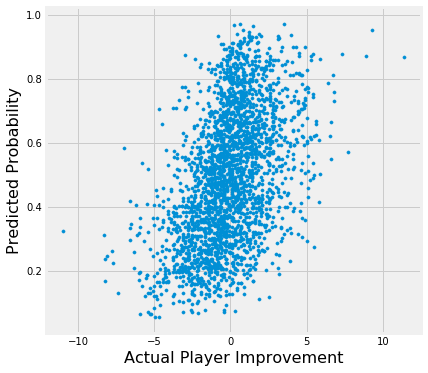

In [36]:
# Plot the predicted probability and true values
def plot_prob_value(model, Xtest, ytest):
    ypred = model.predict_proba(Xtest)[:,1]
    plt.figure(figsize=(6,6))
    _ = plt.scatter(ytest, ypred, s=10)
    _ = plt.xlabel('Actual Player Improvement', fontsize=16)
    _ = plt.ylabel('Predicted Probability', fontsize=16)
plot_prob_value(logreg, Xtest, ytest)

### 3.2 SVM

In [37]:
from sklearn.svm import SVC
clf = SVC(random_state=42, probability=True)
params = {
    'C': [0.1, 1, 10, 100, 1000, 10000],
    'gamma': [1e-4, 0.001, 0.01, 0.1, 1, 10]
}
grid_search_cv_class(clf, params, Xtrain, ytrain_class)

Best parameters were {'C': 10000, 'gamma': 0.001}


In [38]:
svc = SVC(random_state=42, probability=True, C=10000, gamma=0.001)
svc.fit(Xtrain, ytrain_class)
model_evaluation(svc, Xtest, ytest_class)

Accuracy of test set was 0.6730401529636711


True Negative = 936	False Positive = 406
False Negative = 449	True Positive=824


             precision    recall  f1-score   support

          0       0.68      0.70      0.69      1342
          1       0.67      0.65      0.66      1273

avg / total       0.67      0.67      0.67      2615



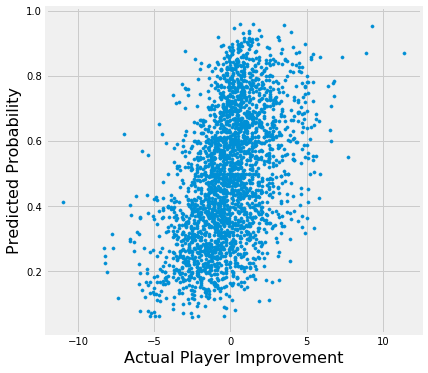

In [39]:
plot_prob_value(svc, Xtest, ytest)

Very similar performances between logistic regression and SVM.
### 3.3 Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
params = {
    'n_estimators': [101, 201, 401, 601, 801, 1001],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 10, 20],
}
grid_search_cv_class(clf, params, Xtrain, ytrain_class)

Best parameters were {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 1001}


In [41]:
rf = RandomForestClassifier(
                   n_estimators=1001, max_depth=10, min_samples_split=10,
                   random_state=42)
rf.fit(Xtrain, ytrain_class)
model_evaluation(rf, Xtest, ytest_class)

Accuracy of test set was 0.6760994263862332


True Negative = 943	False Positive = 399
False Negative = 448	True Positive=825


             precision    recall  f1-score   support

          0       0.68      0.70      0.69      1342
          1       0.67      0.65      0.66      1273

avg / total       0.68      0.68      0.68      2615



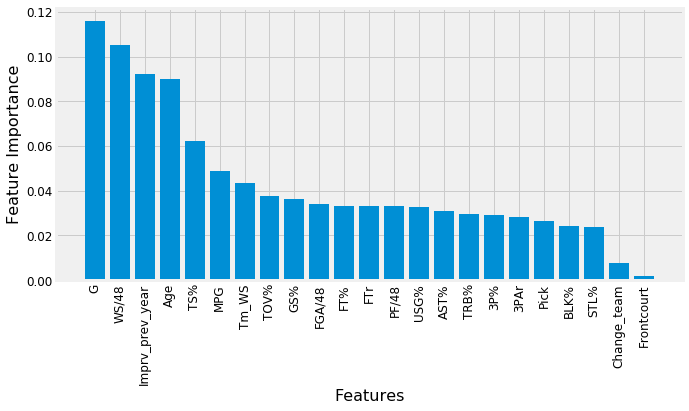

In [42]:
# Plot feature importances.
imp = pd.Series(rf.feature_importances_, index=data.columns)
imp = imp.sort_values(ascending=False)
plt.figure(figsize=(10,5))
_ = plt.bar(range(len(imp)), imp)
_ = plt.xticks(range(len(imp)), imp.index, rotation=90)
_ = plt.xlabel('Features', fontsize=16)
_ = plt.ylabel("Feature Importance", fontsize=16)
_ = plt.xticks(fontsize=12)
_ = plt.yticks(fontsize=12)

### 3.4 Gradient Boost

In [43]:
from sklearn.ensemble import GradientBoostingClassifier
# Use some tuned parameters from random forest, only tune learning rate and n_estimators
clf = GradientBoostingClassifier(
                    min_samples_split=10, max_depth=10,
                    max_features='sqrt', random_state=42)
params = {
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
    'n_estimators': [25, 51, 101, 201, 401, 601, 1001],
}
grid_search_cv_class(clf, params, Xtrain, ytrain_class)

Best parameters were {'learning_rate': 0.005, 'n_estimators': 601}


In [44]:
gb = GradientBoostingClassifier(
                    min_samples_split=10, max_depth=10,
                    max_features='sqrt', random_state=42,
                    learning_rate=0.005, n_estimators=601)
gb.fit(Xtrain, ytrain_class)
model_evaluation(gb, Xtest, ytest_class)

Accuracy of test set was 0.6673040152963671


True Negative = 924	False Positive = 418
False Negative = 452	True Positive=821


             precision    recall  f1-score   support

          0       0.67      0.69      0.68      1342
          1       0.66      0.64      0.65      1273

avg / total       0.67      0.67      0.67      2615



The random forest model had the best performances out of all, but not by much.
### 3.5 Voting Model

In [45]:
from sklearn.ensemble import VotingClassifier
# Make a weights matrix
weights = [[int(x) for x in list("{0:0b}".format(i).zfill(4))] for i in range(1, 2**4)]
print('Weights matrix is', weights)
# Use CV to figure which models to use in the ensumble model
clf = VotingClassifier(
    estimators=[('logreg', logreg), ('svc', svc), ('rf', rf), ('gb', gb)],
    voting='soft')
params = {'weights': weights}
grid_search_cv_class(clf, params, Xtrain, ytrain_class)

Weights matrix is [[0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 1], [0, 1, 0, 0], [0, 1, 0, 1], [0, 1, 1, 0], [0, 1, 1, 1], [1, 0, 0, 0], [1, 0, 0, 1], [1, 0, 1, 0], [1, 0, 1, 1], [1, 1, 0, 0], [1, 1, 0, 1], [1, 1, 1, 0], [1, 1, 1, 1]]
Best parameters were {'weights': [1, 1, 0, 1]}


In [46]:
voting = VotingClassifier(
    estimators=[('logreg', logreg), ('svc', svc), ('gb', gb)],
    voting='soft', weights = [1,1,1])
voting.fit(Xtrain, ytrain_class)
model_evaluation(voting, Xtest, ytest_class)

Accuracy of test set was 0.6669216061185469


True Negative = 912	False Positive = 430
False Negative = 441	True Positive=832


             precision    recall  f1-score   support

          0       0.67      0.68      0.68      1342
          1       0.66      0.65      0.66      1273

avg / total       0.67      0.67      0.67      2615



/Users/zhenfengliu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


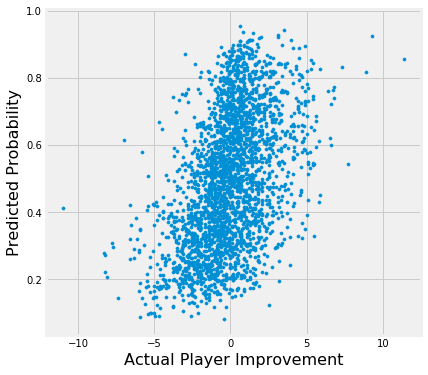

In [47]:
plot_prob_value(voting, Xtest, ytest)

### 3.6 ROC curve

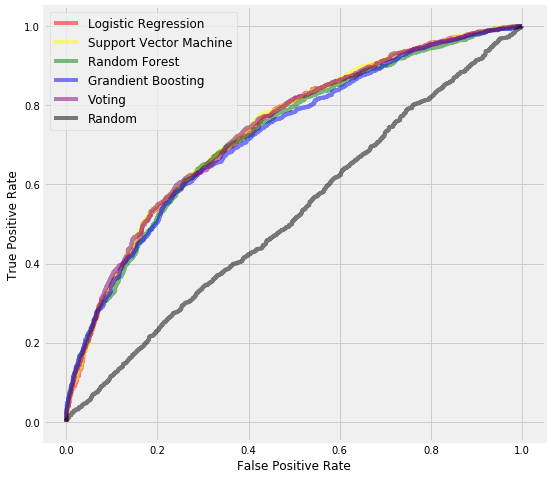

In [48]:
# Plot the precision-recall curve of different models on the test set.
from sklearn.metrics import roc_curve
models = [logreg, svc, rf, gb, voting]
labels = ['Logistic Regression', 'Support Vector Machine',
          'Random Forest', 'Grandient Boosting', 'Voting']
colors = ['red', 'yellow', 'green', 'blue', 'purple']
plt.figure(figsize=(8,8))
for index, model in enumerate(models):
    ypred_prob = model.predict_proba(Xtest)[:,1]
    fpr, tpr, _ = roc_curve(ytest_class, ypred_prob)
    _ = plt.step(fpr, tpr, color=colors[index], alpha=0.5, where='post', label=labels[index])
random = np.random.rand(len(ytest))
fpr, tpr , _ = roc_curve(ytest_class, random)
_ = plt.step(fpr, tpr, color='k', alpha=0.5, where='post', label='Random')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.legend(fontsize=12)

In this problem, we want the false positive rate to be lower. In other words, it is OK to have false negatives (miss some improved players), since a team can only have a limited number of players. But it is really bad to have false positives, because acquiring that player probably means loss of value for the team.

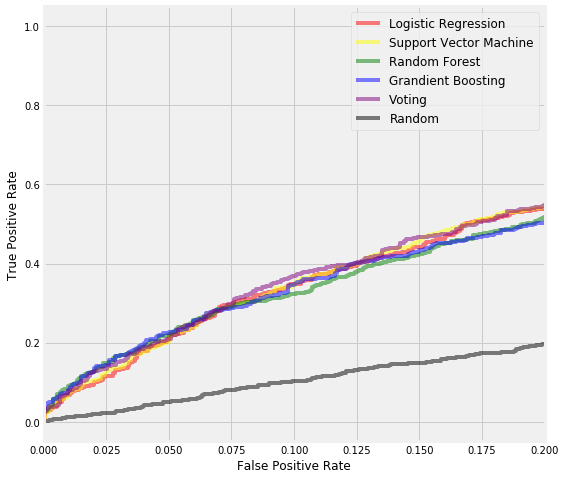

In [49]:
# Re-do the roc curve, but zoom in for false positive rate < 0.2
models = [logreg, svc, rf, gb, voting]
labels = ['Logistic Regression', 'Support Vector Machine',
          'Random Forest', 'Grandient Boosting', 'Voting']
colors = ['red', 'yellow', 'green', 'blue', 'purple']
plt.figure(figsize=(8,8))
for index, model in enumerate(models):
    ypred_prob = model.predict_proba(Xtest)[:,1]
    fpr, tpr, _ = roc_curve(ytest_class, ypred_prob)
    _ = plt.step(fpr, tpr, color=colors[index], alpha=0.5, where='post', label=labels[index])
random = np.random.rand(len(ytest))
fpr, tpr , _ = roc_curve(ytest_class, random)
_ = plt.step(fpr, tpr, color='k', alpha=0.5, where='post', label='Random')
_ = plt.xlim([0, 0.2])
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.legend(fontsize=12)

It seems like the voting model was on or near the top in most cases. But the differences between models were very very small.<br>